In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from models import Classifier, cross_entropy_with_grad
from optimizers import MomentumSGD
from layers import *

In [3]:
np.random.seed(42)

## Посмотрим на данные

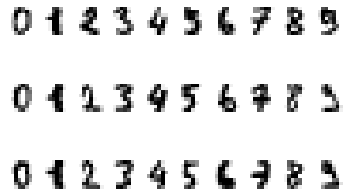

In [4]:
digits = datasets.load_digits()

for plot_index in range(30):
    plt.subplot(3, 10, plot_index + 1)
    plt.imshow(digits.images[plot_index], cmap=plt.cm.gray_r)
    plt.axis('off')

In [5]:
X = digits.images
X.shape

(1797, 8, 8)

## Вычтем из пикселей среднее и добавим размерность

In [6]:
X -= np.mean(X, axis=0)
X = X[:, :, :, np.newaxis]
X.shape

(1797, 8, 8, 1)

In [7]:
y = digits.target
y.shape

(1797,)

## Разобъём выборку

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, shuffle=True, random_state=42)
print(f'Выборки и их размеры. Train:{X_train.shape[0]}, Validation:{X_validation.shape[0]}, Test:{X_test.shape[0]}')

Выборки и их размеры. Train:1149, Validation:288, Test:360


## Вспомогательные функции

In [9]:
def batches_indices(x, batch_size, shuffle=True):
    indices = np.arange(x.shape[0])
    if shuffle:
        np.random.shuffle(indices)
    sections = np.arange(batch_size, x.shape[0], batch_size)
    return np.array_split(indices, sections)

In [10]:
def compute_accuracy(X, y, batch_size, model):
    pred = np.zeros_like(y)
    for batch_indices in batches_indices(X, batch_size, shuffle=False):
        pred[batch_indices] = np.argmax(model(X[batch_indices]), axis=1)
    return accuracy_score(y, pred)

In [11]:
def plot_loss_history(train_history, valid_history):
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(train_history)), train_history, label='train')
    plt.plot(range(len(valid_history)), valid_history, label='validation')
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.legend(prop={'size': 14})
    plt.show()

# Train loop

In [12]:
def train(model, optimizer_class, epochs=20, batch_size=16, **optimizer_args):
    optimizer = optimizer_class(model.parameters(), **optimizer_args)
    
    train_losses, valid_losses = [], []
    
    best_valid_loss = float('inf')
    best_parameters = None
    best_epoch = 0

    for epoch in range(epochs):
        # Train
        epoch_loss = 0.0
        for batch_indices in batches_indices(X_train, batch_size, shuffle=True):
            loss, grad = cross_entropy_with_grad(model(X_train[batch_indices]), y_train[batch_indices])
            optimizer.zero_grad()
            model.backward(grad)
            optimizer.step()
            epoch_loss += loss * len(batch_indices)
        train_losses.append(epoch_loss / len(y_train))
        train_acc = compute_accuracy(X_train, y_train, batch_size, model)

        # Evaluation
        epoch_loss = 0.0
        for  batch_indices in batches_indices(X_validation, batch_size, shuffle=False):
            loss, _ = cross_entropy_with_grad(model(X_validation[batch_indices]), y_validation[batch_indices])
            epoch_loss += loss * len(batch_indices)
        valid_losses.append(epoch_loss / len(y_validation))
        valid_acc = compute_accuracy(X_validation, y_validation, batch_size, model)
        
        print(f'Epoch {epoch} | Train loss {train_losses[-1]} | Validation loss {valid_losses[-1]} | Train accuracy {round(train_acc, 2)} | Validation accuracy {round(valid_acc, 2)}')

        if best_valid_loss > valid_losses[-1]:
            best_valid_loss = valid_losses[-1]
            best_parameters = [parameter.value.copy() for parameter in model.parameters()]
            best_epoch = epoch
            
    print(f'\nЭпоха, на которой был достигнут наименьший Validation loss: {best_epoch}\n')
    for parameter, best_parameter in zip(model.parameters(), best_parameters):
        parameter.value = best_parameter
                            
    return train_losses, valid_losses

## Эксперименты показали, что без MaxPool2d качество лучше.

Epoch 0 | Train loss 5.781864558890051 | Validation loss 1.3815473657856334 | Train accuracy 0.97 | Validation accuracy 0.95
Epoch 1 | Train loss 1.3003178659585493 | Validation loss 2.0922237210390424 | Train accuracy 0.96 | Validation accuracy 0.93
Epoch 2 | Train loss 0.7199480468250689 | Validation loss 0.9949472768155757 | Train accuracy 0.99 | Validation accuracy 0.97
Epoch 3 | Train loss 0.5001455452918331 | Validation loss 0.8394842133319536 | Train accuracy 1.0 | Validation accuracy 0.98
Epoch 4 | Train loss 0.1747177255639048 | Validation loss 0.7195578415606378 | Train accuracy 1.0 | Validation accuracy 0.98
Epoch 5 | Train loss 0.12022511333527737 | Validation loss 0.5023693496133694 | Train accuracy 1.0 | Validation accuracy 0.98
Epoch 6 | Train loss 0.10299348137844636 | Validation loss 0.7207440705891313 | Train accuracy 0.99 | Validation accuracy 0.98
Epoch 7 | Train loss 0.09018004656303369 | Validation loss 0.7886489624987819 | Train accuracy 1.0 | Validation accuracy

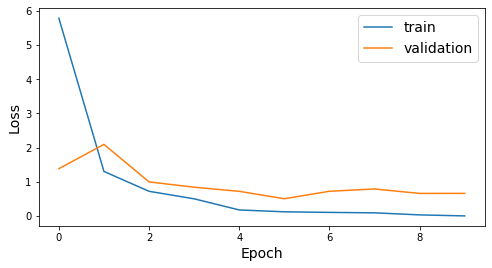


Accuracy на тестовой выборке: 0.9805555555555555


In [13]:
model = Classifier([Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
                    ReLU(),
                    Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
                    ReLU(),
                    Flattener(),
                    Linear(8 * 8 * 32, 10)])

train_history, valid_history = train(model, MomentumSGD, epochs=10, batch_size=16, lr=1e-4, momentum=0.95)

plot_loss_history(train_history, valid_history)

print(f'\nAccuracy на тестовой выборке: {accuracy_score(y_test, np.argmax(model(X_test), axis=1))}')

## Но MaxPool2d работает исправно

Epoch 0 | Train loss 12.101831114888318 | Validation loss 4.47179101656186 | Train accuracy 0.86 | Validation accuracy 0.86
Epoch 1 | Train loss 3.594982876585807 | Validation loss 2.887744857471342 | Train accuracy 0.94 | Validation accuracy 0.9
Epoch 2 | Train loss 1.7411291062275824 | Validation loss 2.372691794093299 | Train accuracy 0.95 | Validation accuracy 0.92
Epoch 3 | Train loss 1.0187571524258041 | Validation loss 2.315119820338174 | Train accuracy 0.97 | Validation accuracy 0.92
Epoch 4 | Train loss 0.7033462280589279 | Validation loss 2.6756109931031777 | Train accuracy 0.95 | Validation accuracy 0.9
Epoch 5 | Train loss 0.9315924241317262 | Validation loss 1.785915050564892 | Train accuracy 0.98 | Validation accuracy 0.93
Epoch 6 | Train loss 0.3719532679957513 | Validation loss 1.6186154813817202 | Train accuracy 0.99 | Validation accuracy 0.94
Epoch 7 | Train loss 0.23136364006019716 | Validation loss 1.596926594594811 | Train accuracy 1.0 | Validation accuracy 0.94
Ep

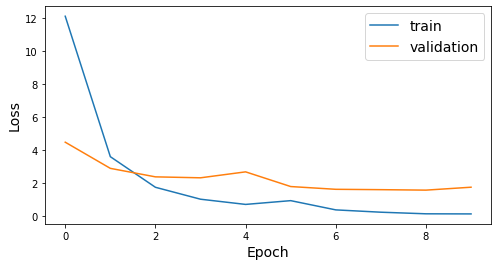


Accuracy на тестовой выборке: 0.9388888888888889


In [14]:
model = Classifier([Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
                    ReLU(),
                    MaxPool2d(2,2),
                    Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
                    ReLU(),
                    Flattener(),
                    Linear(4 * 4 * 32, 10)])

train_history, valid_history = train(model, MomentumSGD, epochs=10, batch_size=16, lr=1e-4, momentum=0.95)

plot_loss_history(train_history, valid_history)

print(f'\nAccuracy на тестовой выборке: {accuracy_score(y_test, np.argmax(model(X_test), axis=1))}')